# V by Vodafone Data Challenge 2018

This project has been developed by Gianmaria Carnazzi, Davide Castellini, Maria Stella Cocco, Matteo Karl Donati, Federico Maria Rosi, Noah Kuntner

---

# Introduction

## How we did it

![](https://imgs.xkcd.com/comics/machine_learning.png)

## How we did it (for real)

The dataset `dataset_challenge_v5.TRAINING.csv` provides information about 2000 customers who have shown interest in one of the four V by Vodafone products.

We are going to go through the following steps in order to profile customers interested in one of the products of concern.

The first problem we dealt with was that of preprocessing the data in order to be able to extract the right information from it. In fact, the dataset present some redundant columns, entries formatted in such a way that they cannot be used for our purposes and some other issues that we will cover in detail in this notebook.

The second challenge we faced was the missing data throughout the dataset. We tried different approaches in order to predict them with the best accuracy possible, so as to be able to perform the final step of our project, clustering.

In order to perform appropriate clustering, we took advantage of some algorithms that we believe can give the best results, as we will show later.

We will go deeply through each point we mentioned above and will provide explanation of our choices throughout the notebook. 

Enjoy.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)

In [7]:
df = pd.read_csv('dataset.csv')

In [8]:
df

,Unnamed: 0,ID,Product,CustomerAge,DataAllowance,DataArpu,DeviceFlag4G,DeviceFlagSmartphone,MonthlyDataTraffic,MonthlyVoiceTrafficCount,CustomerGender,CustomerImmigrant,DevicePrice,MonthlySmsTrafficCount,DeviceOperatingSystem,File-Transfer,Games,Instant-Messaging-Applications,Mail,Music-Streaming,Network-Operation,P2P-Applications,Security,Streaming-Applications,Terminals,Unclassified,VoIP,Web-Applications,Lat,Long,Popolazione,GradoUrbanizzazione,GeoArea
0,0,0,V-Bag,"(80, 90]",0.239013,0.023735,0.0,1.0,0.161215,0.156938,0.0,0.0,NaN,0.001727,iOS,0.105931,0.000398,0.037471,0.006423,0.003853,0.000936,5.491870e-08,0.002637,0.550123,0.0,0.000301,0.000773,0.291156,44.848333,11.070556,6270.0,Medio,Nord
1,1,1,V-Auto,"(60, 70]",0.239013,0.118674,0.0,1.0,0.003784,0.053965,1.0,0.0,NaN,0.000576,NaN,0.293276,0.001141,0.005680,0.017510,0.000000,0.000000,0.000000e+00,0.001790,0.010782,0.0,0.026300,0.011175,0.632345,41.895278,12.482222,2873494.0,Elevato,Centro
2,2,2,V-Auto,"(30, 40]",0.095605,0.178010,1.0,1.0,0.035768,0.039923,0.0,0.0,0.265060,0.000863,Android,0.059897,0.000005,0.017701,0.002635,0.000001,0.000005,2.395075e-05,0.029518,0.372174,0.0,0.011640,0.002848,0.503553,40.131389,18.105278,1890.0,Medio,Sud
3,3,4,V-Bag,"(70, 80]",0.119507,0.249070,0.0,0.0,0.010387,0.147852,1.0,0.0,NaN,0.001151,NaN,0.161202,0.004369,0.131617,0.041048,0.069575,0.016854,0.000000e+00,0.005859,0.134255,0.0,0.003630,0.000030,0.431561,41.635278,13.340278,46120.0,Medio,Centro
4,4,5,V-Pet,"(30, 40]",0.289900,0.083072,0.0,0.0,0.044387,0.064152,1.0,0.0,NaN,0.000288,NaN,0.009266,0.003113,0.009319,0.000072,0.006521,0.001321,7.058996e-05,0.001687,0.327205,0.0,0.000151,0.000748,0.640527,45.316389,8.856111,63505.0,Elevato,Nord
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,2575,V-Camera,"(70, 80]",0.274480,0.158487,1.0,1.0,0.008344,0.053689,1.0,0.0,0.301205,0.000000,Android,0.096625,0.000007,0.050065,0.016410,0.000000,0.000000,2.036320e-04,0.003755,0.053721,0.0,0.010481,0.027276,0.741457,38.017500,12.536667,68528.0,Medio,Isole
1996,1996,2577,V-Auto,"(20, 30]",0.129530,NaN,0.0,1.0,0.133799,0.062500,0.0,0.0,NaN,0.000863,iOS,0.016656,0.000387,0.009179,0.000993,0.003801,0.000698,7.368099e-08,0.000020,0.310806,0.0,0.000231,0.000270,0.656960,NaN,NaN,NaN,NaN,NaN
1997,1997,2578,V-Pet,"(30, 40]",NaN,NaN,0.0,0.0,0.007447,0.011013,0.0,0.0,NaN,0.003741,NaN,0.053797,0.000000,0.033625,0.003913,0.000000,0.000000,0.000000e+00,0.000000,0.458711,0.0,0.002706,0.006772,0.440475,42.516944,12.521111,19543.0,Medio,Centro
1998,1998,2579,V-Auto,"(60, 70]",0.263685,0.142408,0.0,0.0,0.005318,0.047907,1.0,0.0,NaN,0.011799,NaN,0.059852,0.015422,0.080809,0.029712,0.050993,0.047583,0.000000e+00,0.007756,0.013409,0.0,0.006046,0.001453,0.686967,45.606389,8.140000,1009.0,Medio,Nord


---

# Preprocessing

The first two columns contain exactly the same information, therefore one of the two can be deleted.

In [10]:
del df['Unnamed: 0']  

we change the tipe of the categorical 0/1 from float to int

In [11]:
l = ['DeviceFlag4G', 'DeviceFlagSmartphone', 'CustomerGender', 'CustomerImmigrant']

In [12]:
for col in l:
    df[col] = df[col].astype(int)

###  Device Operating System

In the `DeviceOperatingSystem` column two categories dominate over the others, which only combine to form a very small percentage of the total number of devices.  
Thus, we group those categories together into a new one called `Other`.

In [13]:
df['DeviceOperatingSystem'].value_counts()

Android    858
iOS        568
Other       26
Name: DeviceOperatingSystem, dtype: int64

In [14]:
def f(x):
    if not (x =='Android' or x == 'iOS'):
        return 'Other'
    return x

In [15]:
df['DeviceOperatingSystem'] = df['DeviceOperatingSystem'].map(f, na_action='ignore')

### Geographical Data

The data provided, i.e. `Province`, `Region` and `ZipCode`, are not particulary suitable to be used in a learning algorithm, therefore we use those data to extrapolate information that we believe to be more fitting, such as latitude, longitude, degree of urbanization and population.

To get the data of interest we use two datasets.  
The first one, `comuni_ancitel.csv`, contains all the information that we need. The only problem is that we don't have a link beetween our data and the data in the dataset, we therefore rely on another dataset, `comuni_cap`, which enables us to map the zipcodes into the ISTAT numbers, from which we can then obtain the information of interest.

In [12]:
df_comuni = pd.read_csv('comuni_ancitel.csv',sep = ';')
df_cap = pd.read_csv('comuni_cap.csv')
df_cap = df_cap.dropna(axis=0)

The dataset `comuni_cap.csv` is structered in the following way:  
there are three columns, respectively `Comune`, `Cap`, `ISTAT`.  
The information under the `Cap` column are formatted in three different ways (as ranges, lists or numbers) but what we want is each entry to represent a single Cap.  
The code below goes through the dictionary `d`, which maps the zipcodes into the ISTAT numbers using the `comuni_cap.csv` dataset, and creates a new one, namely `d_cap`, which presents the desired structure.

In [13]:
d = df_cap.loc[:,'cap':'ISTAT'].set_index('cap').to_dict()['ISTAT']

In [14]:
import re

In [15]:
d_cap = {}

for s in d:
    if len(s) == 11:
        l = s.split('–')
        l1 = [i for i in range(int(l[0]), int(l[1]) + 1)]
        for cap in l1:
            d_cap[float(cap)] = d[s]
    else:
        l = re.findall(r'\d+', s)
        for cap in l:
            d_cap[float(cap)] = d[s]

Now that we have a dictionary that is suitable to our needs, we can map the zipcodes of the original Vodafone dataset into the ISTAT numbers.  
However we don't map directly from the dictionary because there are some zipcodes that cannot be found and this would lead to a `KeyError`.   
In order to solve this problem we apply the mapping through the function `f` defined below.

In [16]:
def f(x, d):
    if np.isnan(x):
        return x
    
    x = np.int64(x)
    
    try:
        y = d[x]
    except:
        y = np.nan
        
    return y

In [17]:
df['ISTAT'] = df['ZipCode'].apply(f, d = d_cap)

In order to obtain the information we mentioned above (latitude, longitude, degree of urbanization and population), we create dictionaries that map from the ISTAT numbers into the categories of interest.  
Concerning the geographic area, we create another dictionary mapping from the specific regions into the geographic areas (Nord, Centro, Sud, Isole).  

In [18]:
d_lat = df_comuni.loc[:,'ISTAT':'Latitudine'].set_index('ISTAT').to_dict()['Latitudine']
d_long = df_comuni.loc[:,'ISTAT':'Longitudine'].set_index('ISTAT').to_dict()['Longitudine']
d_pop = df_comuni.loc[:,'ISTAT':'PopResidente'].set_index('ISTAT').to_dict()['PopResidente']
d_urb = df_comuni.loc[:,'ISTAT':'GradoUrbaniz'].set_index('ISTAT').to_dict()['GradoUrbaniz']

In [19]:
d_area = {'ABRUZZI': 'Sud',
         'BASILICATA': 'Sud',
         'CALABRIA': 'Sud',
         'CAMPANIA': 'Sud',
         'EMILIA-ROMAGNA': 'Nord',
         'FRIULI-VENEZIA GIULIA': 'Nord',
         'LAZIO': 'Centro',
         'LIGURIA': 'Nord',
         'LOMBARDIA': 'Nord',
         'MARCHE': 'Centro',
         'MOLISE': 'Sud',
         'PIEMONTE': 'Nord',
         'PUGLIA': 'Sud',
         'SARDEGNA': 'Isole',
         'SICILIA': 'Isole',
         'TOSCANA': 'Centro',
         'TRENTINO-ALTO ADIGE': 'Nord',
         'UMBRIA': 'Centro',
         "VALLE D'AOSTA": 'Nord',
         'VENETO': 'Nord'}

We now add the gathered information to the Vodafone datasets.  
As before, we are not able to directly apply the map from the dictionaries since there are some ISTAT numbers that cannot be found in `comuni_ancitel.csv`, so we rely again on the `f` function.


In [20]:
df['Lat'] = df['ISTAT'].apply(f, d = d_lat)
df['Long'] = df['ISTAT'].apply(f, d = d_long)
df['Popolazione'] = df['ISTAT'].apply(f, d = d_pop)
df['GradoUrbanizzazione'] = df['ISTAT'].apply(f, d = d_urb)

In [21]:
df['GeoArea'] = df['Region'].map(lambda x: d_area[x], na_action='ignore')

Latitude and Longitude are not recognised as floats since they use the comma to separate the decimal values instead of the dot.  
To deal with this problem we first transform them in string and then use the method `replace`.

In [22]:
df['Lat'] = df['Lat'].map(lambda x: float(str(x).replace(",", ".")), na_action='ignore')
df['Long'] = df['Long'].map(lambda x: float(str(x).replace(",", ".")), na_action='ignore')

Now that `Latitude` and `Longitude` are correctly recognised we can plot them using a scatter plot.

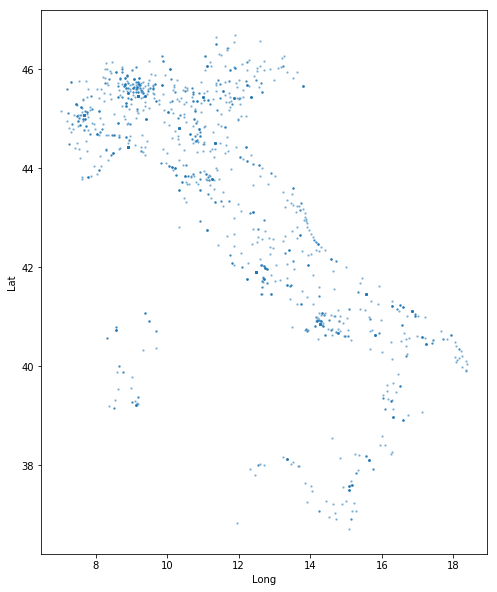

In [23]:
df.plot(kind='scatter', x='Long', y='Lat', alpha=100/256, s=2, figsize=(8,10))

To see if there is any relevant pattern we plot the users again, but this time we assign to each specific product a different color.

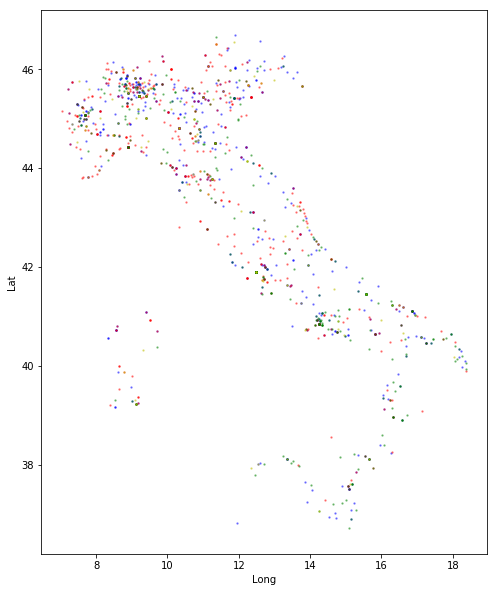

In [24]:
v_bag = df['Product'] == 'V-Bag'
v_pet = df['Product'] == 'V-Pet'
v_auto = df['Product'] == 'V-Auto'
v_camera = df['Product'] == 'V-Camera'

ax = df[v_bag].plot(kind='scatter', x='Long', y='Lat', alpha=100/256, s=2, figsize=(8,10), color='b')
ax = df[v_pet].plot(kind='scatter', x='Long', y='Lat', alpha=100/256, s=2, figsize=(8,10), color='r', ax=ax)
ax = df[v_auto].plot(kind='scatter', x='Long', y='Lat', alpha=100/256, s=2, figsize=(8,10), color='g', ax=ax)
ax = df[v_camera].plot(kind='scatter', x='Long', y='Lat', alpha=100/256, s=2, figsize=(8,10), color='y', ax=ax)

We can now delete the columns that we believe to be not particulary useful for our purpose.

In [25]:
del df['Province']
del df['Region']
del df['ZipCode']
del df['ISTAT']

---

Let's deal with the missing values in the dataset.

# Missing Data

These are the main steps covered in this part of the notebook:
 - Visualization of the missing data to gain a better understanding of the problem 
 - Imputation of the missing data through different methods such as Supervised Learning, Median Imputation, sampling from the distribution, etc...

## Visualizing the Missing Data

Let's now use the module missingno to get an overview of the missing values by looking for possible correlations and patterns that can help understand relations between categories. 

In [26]:
import missingno as miss

The graph pictures a matrix with the missing data represented by white lines, while the sparkline at the end summarizes the general shape of the data completeness and points out the maximum and minimum rows.

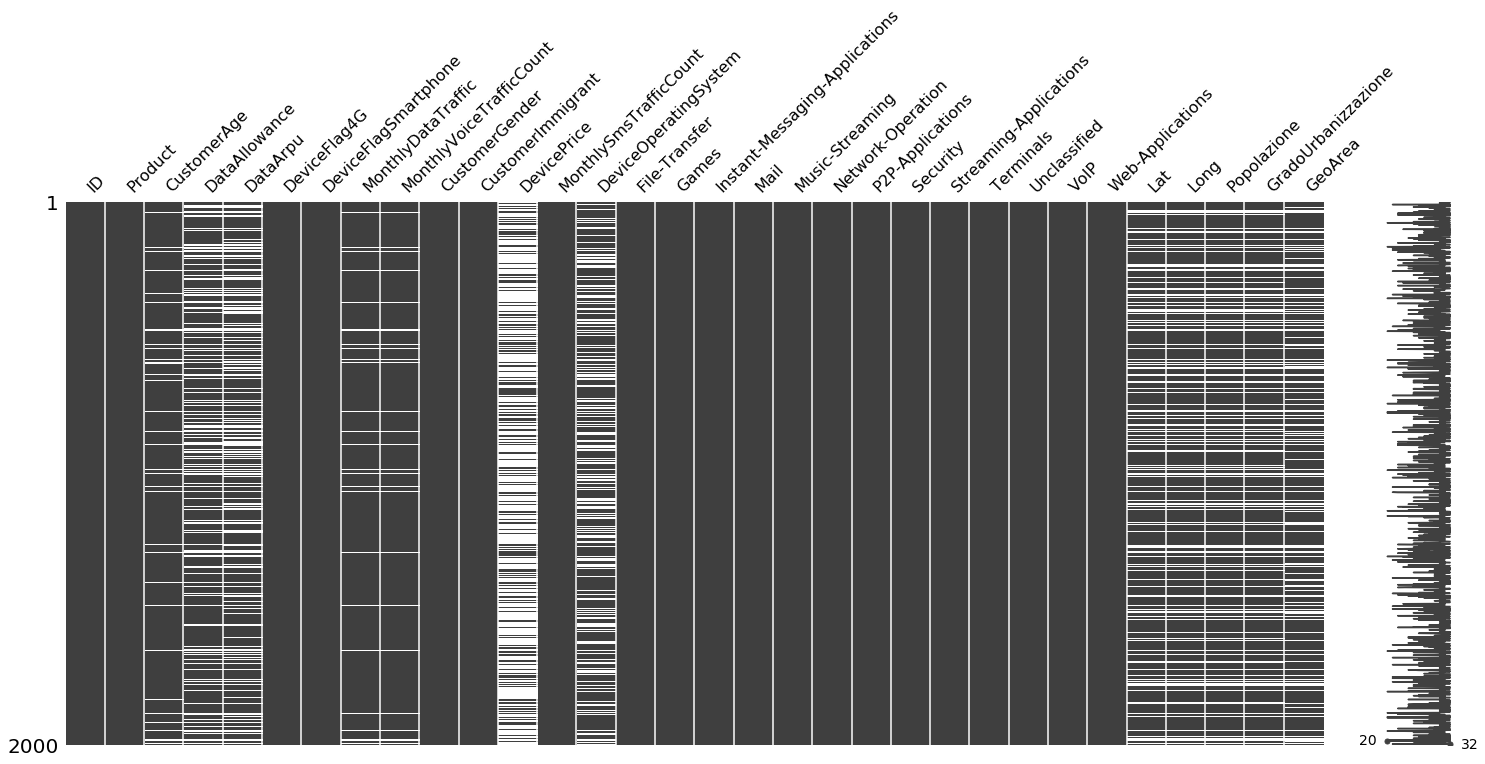

In [27]:
miss.matrix(df)

The histogram shows the amount of data available for each category.

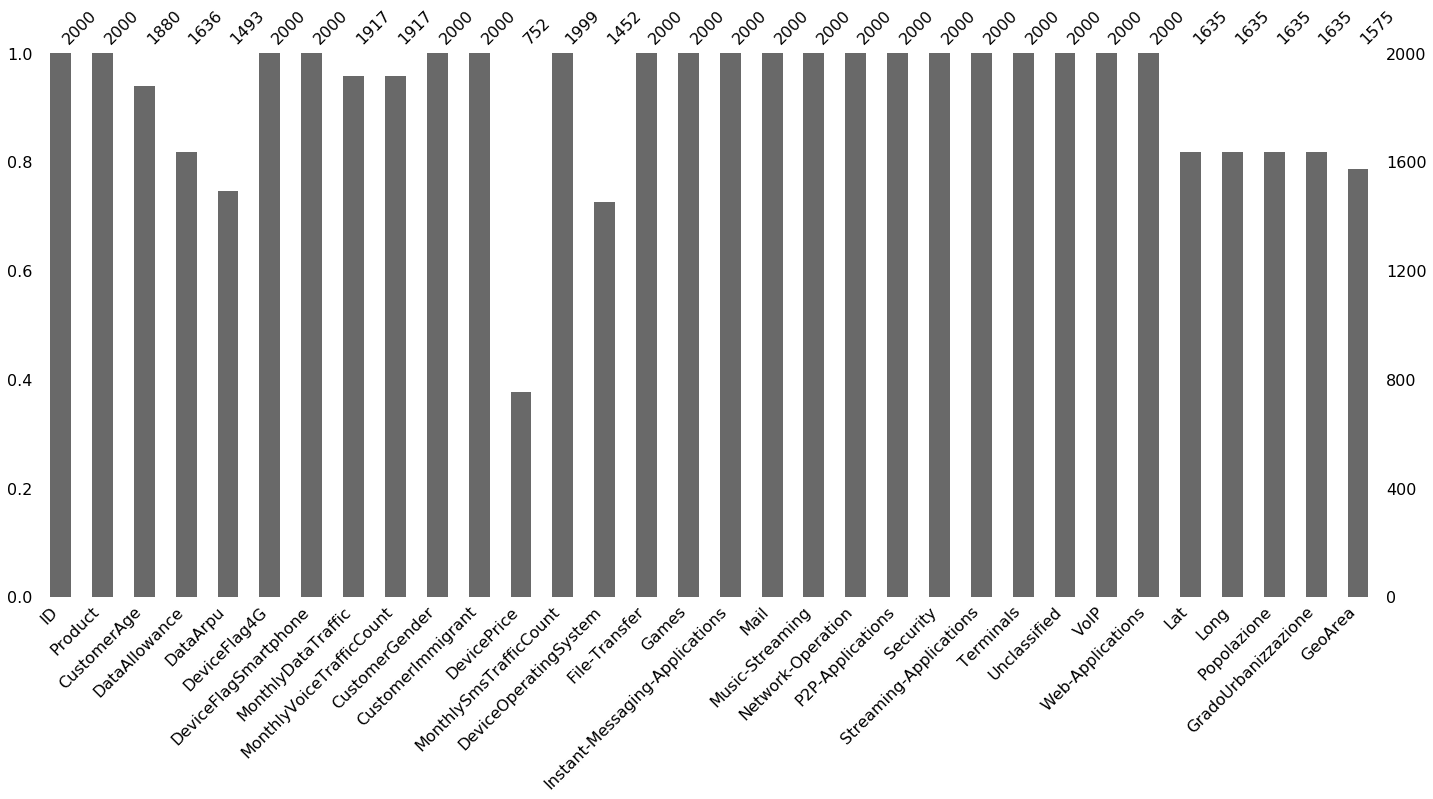

In [28]:
miss.bar(df)

The graph below provides another point of view of the missing values.   
Nullity correlation ranges from -1 (if one variable appears and the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).   
Variables that are always full or always empty have no meaningful correlation, and so are removed from the visualization, in our case all the traffic columns are removed.   
Entries marked < 1 or > -1 have a correlation that is close to be exactly positive or negative, but is still not quite perfect. If the nullity correlation is very close to zero (-0.05 < R < 0.05), no value will be displayed. 
Red cells mean negative correlation.   
Some correlations are not surprising like the positive one between `Province`, `Region` and `GeoArea`, or `ZipCode` with `Province` and `Region`, others are quite interesting like `MonthlyDataTraffic` and `MonthlyVoiceTrafficCount` with `CustomerAge`.    
The heatmap works great for picking out data completeness relationships between variable pairs, but its explanatory power is limited when it comes to larger relationships and it has no particular support for extremely large datasets.   

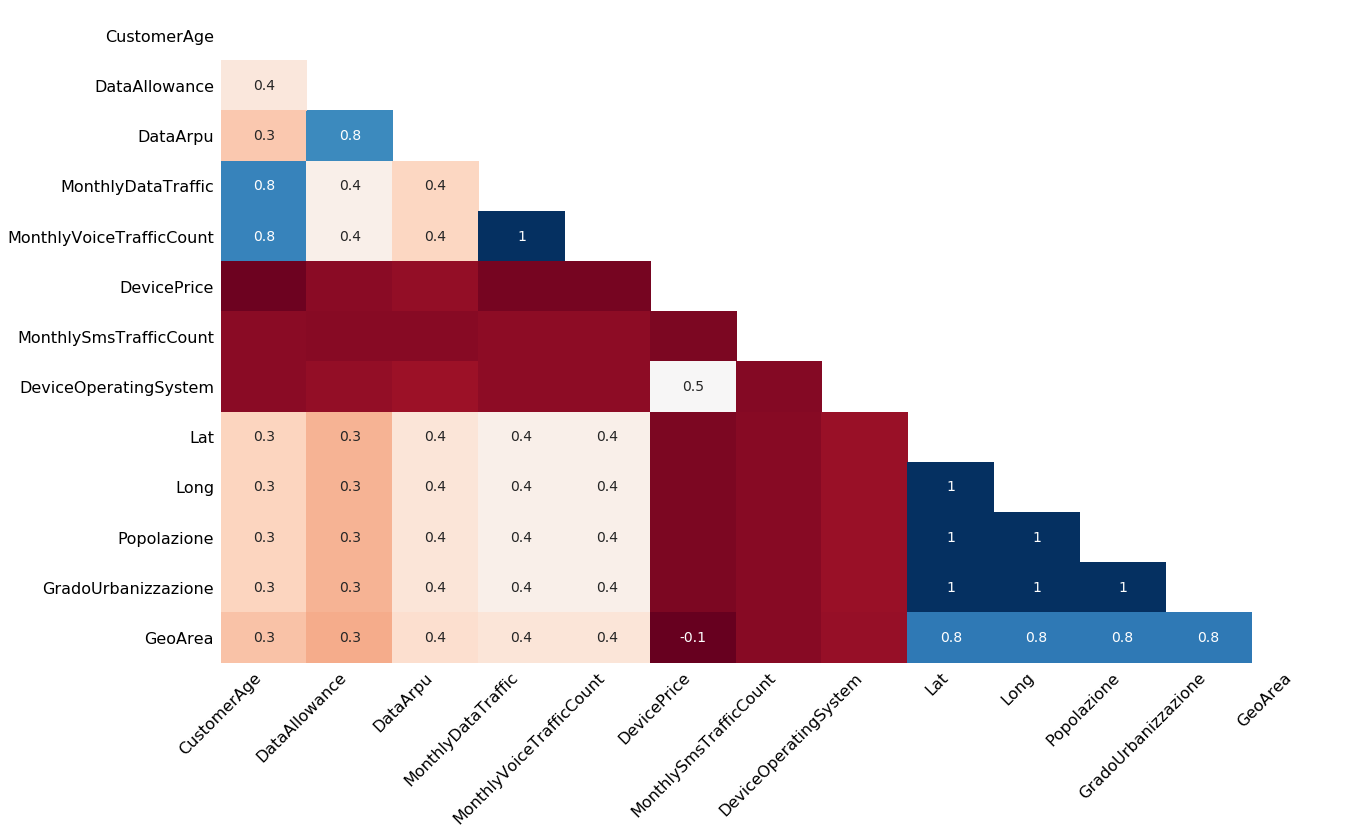

In [29]:
miss.heatmap(df)

The dendrogram reveals correlations deeper than the pairwise ones of the heatmap. It uses a hierarchical clustering algorithm (from scipy.cluster.hierarchy) to bin variables against one another by their nullity correlation, measured in terms of binary distance. At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero. 
Cluster leaves which linked together at a distance of zero fully predict one another's presence: one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. 
Cluster leaves which split close to zero, but not at it, predict one another very well, but still imperfectly.
We notice the same correlations of the heatmap with others less strong that can be considered anyway.

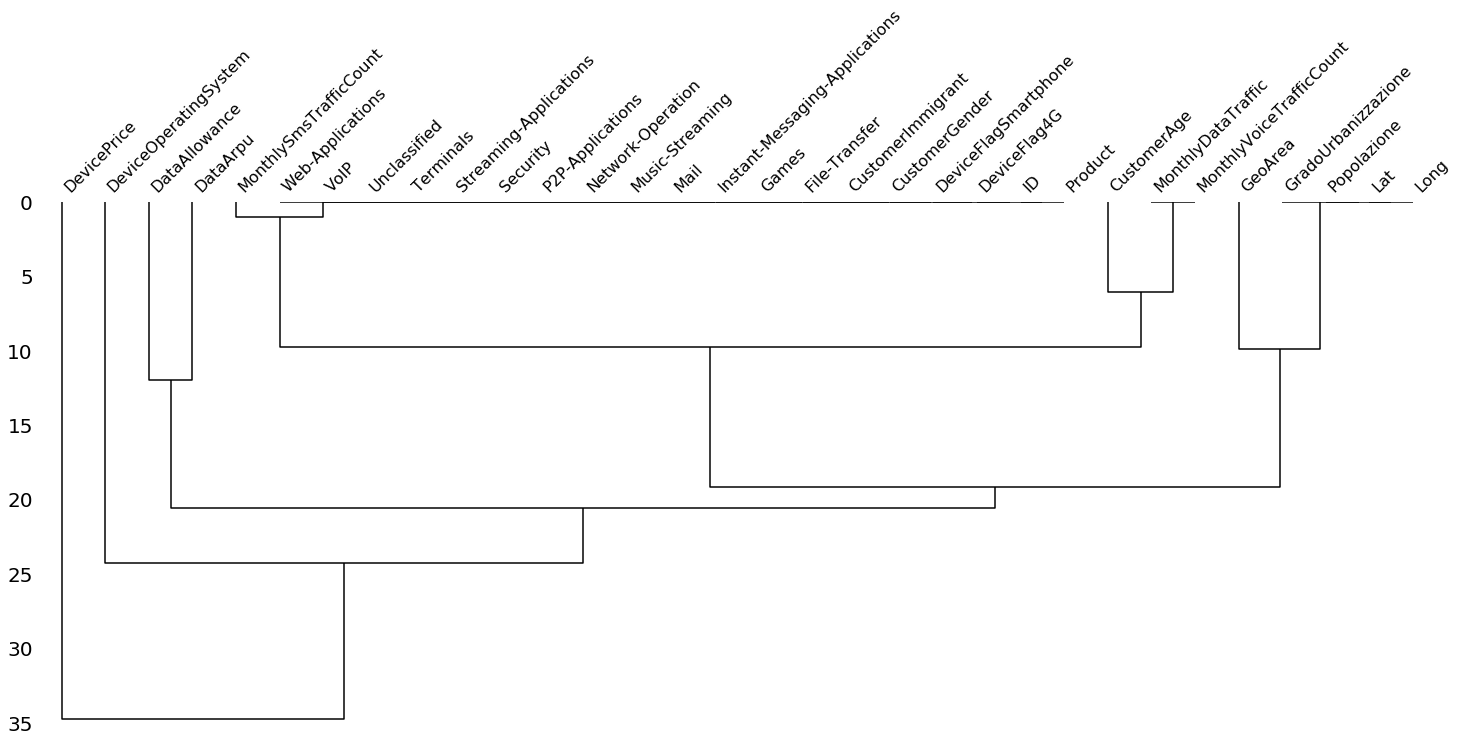

In [30]:
miss.dendrogram(df)

## Imputation

Let's now initialize some functions and methods that will prove useful in the predictions of the missing data.

This function predicts the missing data of a column by sampling randomly from the distribution of that column.

In [31]:
def replace_nan_from_distr(column):
    n = 2000 - df[column].count()
    
    s = df[column].dropna().sample(n)
    s.index = np.where(df[column].isnull())[0]
    
    return df[column].fillna(s)

The function below takes in as arguments a predictive model, which is used to fill the missing data, the columns used for the prediction and the label, which is the column to be predicted.

In [32]:
def fill_nan(predictor, columns, label):
    train = df[columns + label].dropna()
    to_predict = df[columns + label][~df[columns + label].index.isin(train.index)]
    X_train, X, y_train = train[columns], to_predict[columns], train[label[0]]
    
    predictor.fit(X_train, y_train)
    
    label_missing_data = pd.DataFrame(predictor.predict(X))
    
    label_missing_data.index = np.where(df[label].isnull())[0]
    
    return df[label[0]].fillna(label_missing_data[0])

The following class is used to split the data into train set and validation set and it offers the possibility to perform normalization or PCA.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [19]:
class Data:
    def __init__(self, columns, label, df = df, seed=42):
        data = df[columns + label].dropna()
        X = data[columns]
        y = data[label[0]]
        
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        self.X, self.y = x_train, y_train
        self.vX, self.vy = x_test, y_test
    
    def train(self):
        return self.X, self.y
    
    def valid(self):
        return self.vX, self.vy

Let's now import the necessary packages for the application of the supervised learning algorithms and create functions that will help us use those algorithms.
These are the methods performed:
- Multi Perceptron
- Multi Layer Perceptron
- Random Forest
- Regression
- Ridge
- Bayesian Ridge

In [35]:
from sklearn.linear_model import SGDClassifier

In [36]:
def perc(columns, labels, **perc_params):
    
    data = Data(columns, labels)
    
    perc = SGDClassifier(**perc_params)
    perc.fit(*data.train())
    
    tscore = perc.score(*data.train())
    vscore = perc.score(*data.valid())
    
    print("final tscore=%g vscore=%g" % (tscore, vscore))
    
    return perc, data, tscore, vscore

In [37]:
from sklearn.linear_model import SGDRegressor

In [38]:
def reg(columns, labels, **reg_params):
    
    data = Data(columns, labels)
    
    reg = SGDRegressor(**reg_params)
    reg.fit(*data.train())
    
    tscore = reg.score(*data.train())
    vscore = reg.score(*data.valid())
    
    print("final tscore=%g vscore=%g" % (tscore, vscore))
    
    return reg, data, tscore, vscore

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
def rfc(columns, labels, **rfc_params):
    
    data = Data(columns, labels)
    
    rfc = RandomForestClassifier(**rfc_params)
    rfc.fit(*data.train())
    
    tscore = rfc.score(*data.train())
    vscore = rfc.score(*data.valid())
    
    print("final tscore=%g vscore=%g" % (tscore, vscore))
    
    return rfc, data, tscore, vscore

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
def rfr(columns, labels,n_iter = 10, **rfr_params):
    
    data = Data(columns, labels)
    
    score = -1
    
    for j in range(n_iter):
        rfr = RandomForestRegressor(**rfr_params)
        rfr.fit(*data.train())
    
        tscore = rfr.score(*data.train())
        vscore = rfr.score(*data.valid())
        
        if vscore > score:
            rfr_, tscore_, vscore_ = rfr, tscore, vscore
            score = vscore
    
    print("final tscore=%g vscore=%g" % (tscore_, vscore_))
    
    return rfr_, data, tscore_, vscore_

In [43]:
from sklearn.neural_network import MLPClassifier 

In [44]:
def mlpc(columns, labels, **mlp_params):
    
    data = Data(columns, labels)

    mlperc = MLPClassifier(**mlp_params)
    max_iter = mlp_params.pop('max_iter')
    
    tscores = []
    vscores = []
    
    for epoch in range(max_iter):
        
        mlperc.set_params(max_iter=epoch+1)
        mlperc.fit(*data.train())
        
        tscore = mlperc.score(*data.train())
        vscore = mlperc.score(*data.valid())
        
        loss = mlperc.loss_
        tscores.append(tscore)
        vscores.append(vscore)
        
        mlperc.set_params(warm_start=True) 
    
    print("final tscore=%g vscore=%g" % (tscore, vscore))
    
    return mlperc, data, tscores, vscores

In [45]:
from sklearn.neural_network import MLPRegressor

In [46]:
def mlpr(columns, labels, **mlp_params):
    
    data = Data(columns, labels)
    
    mlperc = MLPRegressor(**mlp_params)
    max_iter = mlp_params.pop('max_iter')
    
    tscores = []
    vscores = []
    
    for epoch in range(max_iter):
        
        mlperc.set_params(max_iter=epoch+1)
        mlperc.fit(*data.train())
        
        tscore = mlperc.score(*data.train())
        vscore = mlperc.score(*data.valid())
        
        loss = mlperc.loss_
        tscores.append(tscore)
        vscores.append(vscore)
        
        mlperc.set_params(warm_start=True)
    
    print("final tscore=%g vscore=%g" % (tscore, vscore))
    
    return mlperc, data, tscores, vscores

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
def regression(columns, labels, **reg_params):
    
    data = Data(columns, labels)
    
    lm = LinearRegression(**reg_params)
    
    lm.fit(*data.train())
    
    tscore = lm.score(*data.train())
    vscore = lm.score(*data.valid())
    
    print("final tscore=%g vscore=%g" % (tscore, vscore))

    return lm, data, tscore, vscore

In [49]:
from sklearn.linear_model import Ridge

In [50]:
def ridge(columns, labels, **ridge_params):
    
    data = Data(columns, labels)
    
    lm = Ridge(**ridge_params)
    lm.fit(*data.train())
    
    tscore = lm.score(*data.train())
    vscore = lm.score(*data.valid())
    
    print("final tscore=%g vscore=%g" % (tscore, vscore))

    return lm, data, tscore, vscore

In [51]:
from sklearn.linear_model import BayesianRidge

In [52]:
def b_ridge(columns, labels, **b_ridge_params):
    
    data = Data(columns, labels)
    
    lm = BayesianRidge(**b_ridge_params)
    lm.fit(*data.train())
    
    tscore = lm.score(*data.train())
    vscore = lm.score(*data.valid())
    
    print("final tscore=%g vscore=%g" % (tscore, vscore))

    return lm, data, tscore, vscore

In [24]:
traffic_columns = ['File-Transfer', 'Games',
                   'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
                   'Network-Operation', 'P2P-Applications', 'Security',
                   'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
                   'Web-Applications']
columns = traffic_columns + ['DeviceFlag4G', 'DeviceFlagSmartphone', 'CustomerGender', 'CustomerImmigrant']

Now, for each category which presents missing data, we try to find the best methods to fill the NaN.  
To evaluate the reliability of our model, we take into account the accuracy (for the categorical columns) and the R^2 for the numerical columns.
For now, we consider satisfactory only the predictions with an accuracy greater than 0.5 and an R^2 greater than 0.1.   
We then look at the distributions before and after the imputation and look at how they are affected by the predictions.   
As a final step, we decide whether to use the predictive model, to use imputation by mean, median or mode, or to perform random sampling from the distribution.   

We only show the two best result that we found for each category.

### Categorical Columns

We now introduce a function , plot_comparison_categorical, which will helpus at noticing how the distribution is influenced by filling the NaN through the use of the chosen method.
Random Forest and random sampling from the distribution are the methods that have given the best results. Therefore, we print the original distribution on the left, the distribution after predicting with Random Forest in the centre and the distribution after sampling from the column on the right.

In [54]:
def plot_comparison_categorical(label):

    fig = plt.figure(figsize = (16, 5))

    ax = fig.add_subplot(1, 3, 1)
    df[label].hist()
    plt.title('True Distribution of %s' %label)

    ax = fig.add_subplot(1, 3, 2)
    rf_nan.hist(color='green')
    plt.title('After Predicting with Random Forest')
    
    ax = fig.add_subplot(1, 3, 3)
    distr_nan.hist(color='red')
    plt.title('After Sampling from Distribution') 

#### DeviceOperatingSystem

In [55]:
label = ['DeviceOperatingSystem']

In [56]:
df['DeviceOperatingSystem'].value_counts()

Android    858
iOS        568
Other       26
Name: DeviceOperatingSystem, dtype: int64

Random Forest Classifier:

In [57]:
rfc_, data, tscore, vscore = rfc(columns, label, n_estimators=117, criterion='gini', max_depth=None,
                                     min_samples_split=5, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                     max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False,
                                     n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

final tscore=0.990525 vscore=0.965636


Multilayer Perceptron:

In [58]:
mlp, data, tscores, vscores = mlpc(columns, label, max_iter=800, hidden_layer_sizes = (200,),
                                       batch_size = 110, learning_rate_init=1e-1, solver = 'adam',
                                       learning_rate = 'constant', momentum = 0.0, nesterovs_momentum = False,
                                       verbose = False, alpha=0.0, tol = -1) 

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final tscore=0.964686 vscore=0.876289


From the plot we can see that the score improves greatly in the first 100 iterations, and then it stabilizes although a lot of variability remains.

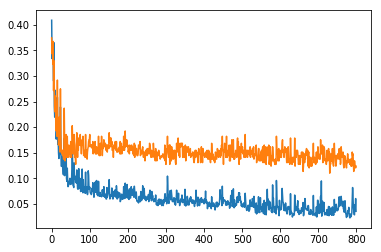

In [59]:
plt.plot(range(len(tscores)), 1-np.array(tscores), range(len(vscores)), 1-np.array(vscores));

Both methods give satisfactory results, in particular Random Forest, in which we get a validation score of 0.96.
Thus, we proceed by using the Random Forest Classifier to predict the DeviceOperatingSystem column.

In [60]:
df['DeviceOperatingSystem'] = fill_nan(rfc_, columns, label)

#### CustomerAge

In [29]:
label = ['CustomerAge']

In [23]:
df['CustomerAge'].value_counts()

(40, 50]    557
(50, 60]    409
(30, 40]    380
(20, 30]    269
(60, 70]    182
(70, 80]     62
(10, 20]     12
(80, 90]      9
Name: CustomerAge, dtype: int64

Random Forest Classifier:

In [25]:
rfc_, data, tscore, vscore = rfc(columns, label, n_estimators=117, criterion='gini', max_depth=None,
                                     min_samples_split=5, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                     max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False,
                                     n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

final tscore=0.999335 vscore=0.340426


MLPClassifier:

In [64]:
mlp, data, tscores, vscores = mlpc(columns, label, max_iter=1000, hidden_layer_sizes = (150,),
                                     batch_size = 120, learning_rate_init=1e-1, solver = 'adam',
                                     learning_rate = 'constant', momentum = 0.0, nesterovs_momentum = False,
                                     verbose = False, alpha=0.0, tol = -1)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final tscore=0.347739 vscore=0.273936


It is clear from the plot that the algorithm struggle to find an optima.

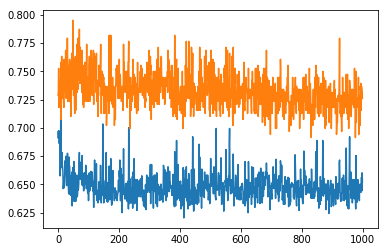

In [65]:
plt.plot(range(len(tscores)), 1-np.array(tscores), range(len(vscores)), 1-np.array(vscores));

In this case we cannot obtain applicable results with any learning models.   
we see what would happen to the distribution if we filled the missing values by sampling at random from the column.

In [66]:
rf_nan =  fill_nan(rfc_, columns, label)

In [67]:
distr_nan = replace_nan_from_distr('CustomerAge')

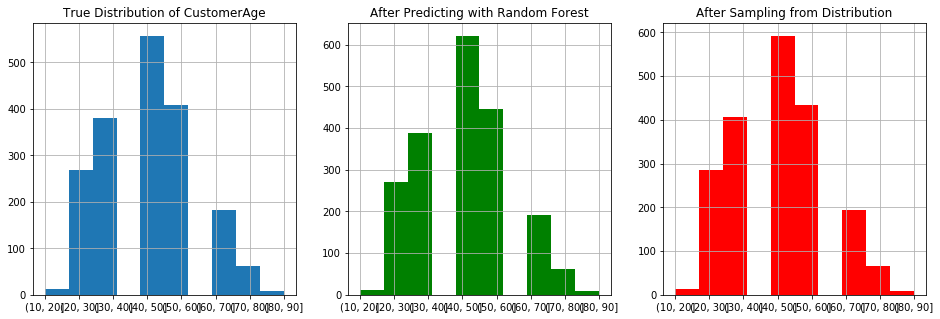

In [68]:
plot_comparison_categorical('CustomerAge')

We decide to predict the missing values using the Random Forest algorithm.

In [69]:
df['CustomerAge'] = fill_nan(rfc_, columns, label)

#### GradoUrbanizzazione 

In [70]:
label = ['GradoUrbanizzazione']

In [71]:
df['GradoUrbanizzazione'].value_counts()

Elevato    763
Medio      609
Basso      263
Name: GradoUrbanizzazione, dtype: int64

Random Forest Classifier:

In [72]:
rfc_, data, tscore, vscore = rfc(columns, label, n_estimators=117, criterion='gini', max_depth=None,
                                     min_samples_split=5, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                     max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False,
                                     n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

final tscore=1 vscore=0.461774


MLPClassifier:

In [73]:
mlp, data, tscores, vscores = mlpc(columns, label, max_iter=3000, hidden_layer_sizes = (210,),
                                     batch_size = 120, learning_rate_init=1e-1, solver = 'sgd',
                                     learning_rate = 'constant', momentum = 0.0, nesterovs_momentum = False,
                                     verbose = False, alpha=0.0, tol = -1)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final tscore=0.532875 vscore=0.428135


Also in this case we notice that the multi layer perceptrone does not converge as the number of iterations grows.

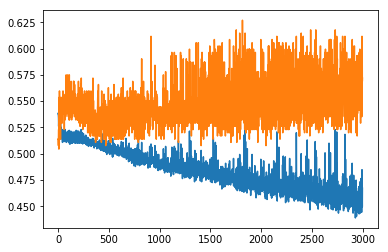

In [74]:
plt.plot(range(len(tscores)), 1-np.array(tscores), range(len(vscores)), 1-np.array(vscores));

In both cases we obtain results around 0.5. They are not completely satisfactory but we do not a priori refuse to use them.   
We try to predict the results by random sampling from the distribution and compare how this method behaves with respect to the prediction.

In [75]:
rf_nan =  fill_nan(rfc_, columns, label)

In [76]:
distr_nan = replace_nan_from_distr('GradoUrbanizzazione')

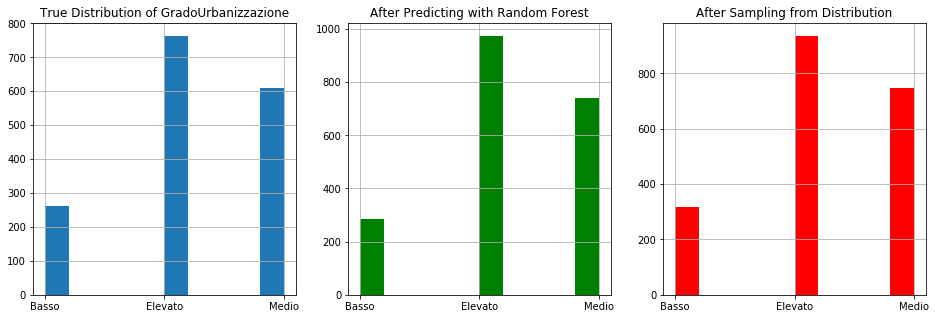

In [77]:
plot_comparison_categorical('GradoUrbanizzazione')

We decide to use the prediction with Random Forest, as the score is acceptable and it behaves quite well with respect to the original distribution.

In [78]:
df['GradoUrbanizzazione'] = fill_nan(rfc_, columns, label)

#### GeoArea

In [79]:
label = ['GeoArea']

In [80]:
df['GeoArea'].value_counts()

Nord      808
Centro    337
Sud       316
Isole     114
Name: GeoArea, dtype: int64

Random Forest Classifier:

In [81]:
rfc_, data, tscore, vscore = rfc(columns, label, n_estimators=117, criterion='gini', max_depth=None,
                                    min_samples_split=5, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                    max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False,
                                    n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

final tscore=0.999206 vscore=0.501587


MLPClassifier:

In [82]:
mlp_, data, tscores, vscores = mlpc(columns, label, max_iter=1000, hidden_layer_sizes = (200,),
                                     batch_size = 100, learning_rate_init=1e-1, solver = 'adam',
                                     learning_rate = 'constant', momentum = 0.0, nesterovs_momentum = False,
                                     verbose = False, alpha=0.0, tol = -1)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


final tscore=0.546032 vscore=0.488889


Only God knows what the algorithm is doing

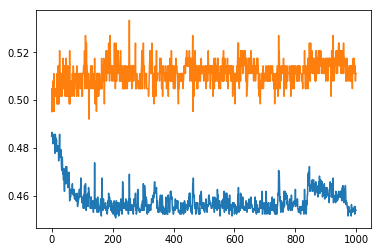

In [83]:
plt.plot(range(len(tscores)), 1-np.array(tscores), range(len(vscores)), 1-np.array(vscores));

The scores are very similar to what we have encountered in GradoUrbanizzazione. Therefore, we proceed in the same way.

In [84]:
rf_nan = fill_nan(rfc_, columns, label)

In [85]:
distr_nan = replace_nan_from_distr('GeoArea')

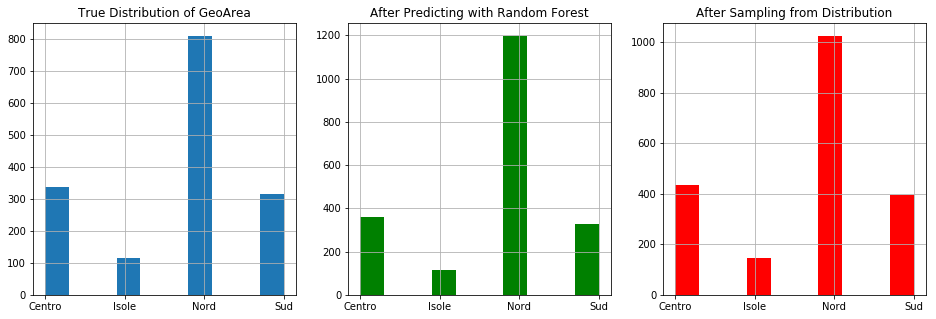

In [86]:
plot_comparison_categorical('GeoArea')

In [87]:
df['GeoArea'] = fill_nan(rfc_, columns, label)

### Numerical Columns

Regarding the numerical columns, we proceed by looking at the score obtained with Random Forest and with the regression, plotting the density that we would obtain using this method and comparing it to what we would get if we used the median to fill the missing values.

In [88]:
def plot_comparison_numerical(label, figsize = (16, 5)):

    fig = plt.figure(figsize = figsize)

    ax = fig.add_subplot(1, 3, 1)
    df[label].plot.density()
    plt.title('True Distribution of %s' %label)

    ax = fig.add_subplot(1, 3, 2)
    rf_nan.plot.density(color='green')
    plt.title('After Predicting with Random Forest')
    
    ax = fig.add_subplot(1, 3, 3)
    median_nan.plot.density(color='red')
    plt.title('After Replacing with the Median')

#### DataAllowance

In [89]:
label = ['DataAllowance']

Random Forest Regressor:

In [90]:
rfr_, data, tscore, vscore = rfr(columns, label, n_iter = 100)

final tscore=0.810006 vscore=0.0566766


Ridge:

In [91]:
ri, data, tscores, vscores = ridge(columns, label)

final tscore=0.0411599 vscore=-0.0161282


The results obtained with Random Forest and with Ridge are highly unsatisfactory. Therefore, we make a comparison between using the prediction and using the median to fill the NaN in order to verify if using the median would be a better choice.

In [92]:
median_nan = df['DataAllowance'].fillna((df['DataAllowance'].median()), inplace=False)

In [93]:
rf_nan =  fill_nan(rfr_, columns, label)

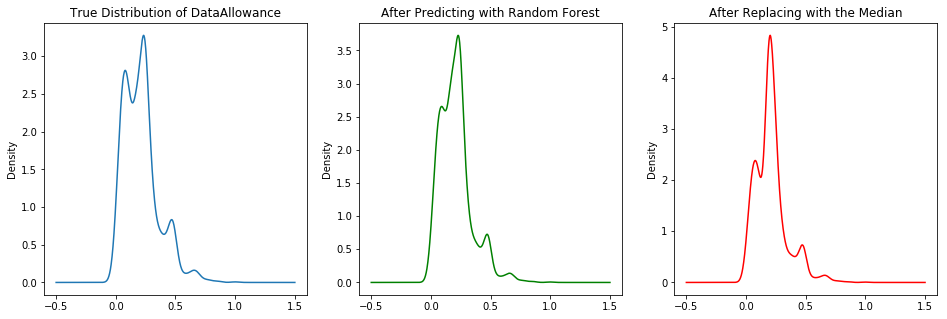

In [94]:
plot_comparison_numerical('DataAllowance')
    

As we can see from the plots, Random Forest is the method that less alters the distribution.
Thus, we proceed by using the latter algorithm.

In [95]:
df['DataAllowance'] = fill_nan(rfr_, columns, label)

#### DataArpu

In [96]:
label = ['DataArpu']

Random Forest Regressor:

In [97]:
rfr_, data, tscore, vscore = rfr(columns, label, n_iter = 100)

final tscore=0.783096 vscore=-0.0794081


Bayesian Ridge:

In [98]:
br, data, tscores, vscores = b_ridge(columns, label)

final tscore=0.0122294 vscore=0.00458713


As with the DataAllowance column, the results obtained with the prediction are not good at all. Hence, we see if filling the NaN with the median would be preferable.

In [99]:
median_nan = df['DataArpu'].fillna((df['DataArpu'].median()), inplace=False)

In [100]:
rf_nan =  fill_nan(rfr_, columns, label)

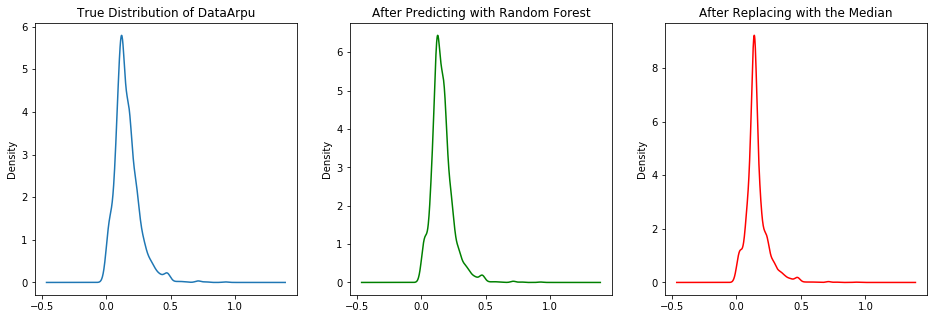

In [101]:
plot_comparison_numerical('DataArpu')

We proceed by using Random Forest as it seems to resemble the original distribution slightly better than the distribution obtained after replacing with the median.

In [102]:
df['DataArpu'] = fill_nan(rfr_, columns, label)

qui non ha senso

#### MontlyVoiceTrafficCount

Now, in the next two columns, MonthlyVoiceTrafficCount and MonthlyDataTraffic, there are very few values missing (only 83).  
Therefore, as shown in the plots, predicting or replacing them with the median does not make any relevant difference.

In [103]:
label = ['MonthlyVoiceTrafficCount']

In [104]:
df['MonthlyVoiceTrafficCount'].count()

1917

Random Forest Regressor:

In [105]:
rfr_, data, tscore, vscore = rfr(columns, label, n_iter = 100)

final tscore=0.820044 vscore=0.0918087


Bayesian Ridge:

In [106]:
br, data, tscores, vscores = b_ridge(columns, label)

final tscore=0.0289924 vscore=0.0282695


In [107]:
median_nan = df['MonthlyVoiceTrafficCount'].fillna((df['MonthlyVoiceTrafficCount'].median()), inplace=False)

In [108]:
rf_nan =  fill_nan(rfr_, columns, label)

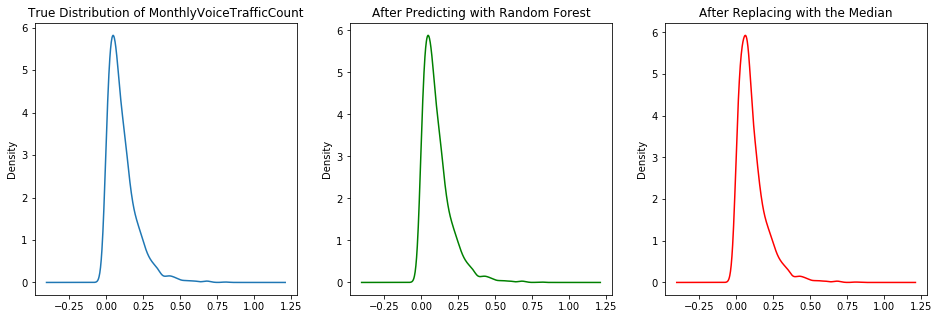

In [109]:
plot_comparison_numerical('MonthlyVoiceTrafficCount')

In [110]:
df['MonthlyVoiceTrafficCount'] = fill_nan(rfr_, columns, label)

qui non ha senso

#### MonthlyDataTraffic

In [111]:
label = ['MonthlyDataTraffic']

In [112]:
df['MonthlyDataTraffic'].count()

1917

Random Forest Regressor:

In [113]:
rfr_, data, tscore, vscore = rfr(columns, label, n_iter = 100)

final tscore=0.863525 vscore=0.223733


Bayesian Ridge:

In [114]:
lm, data, tscore, vscore = b_ridge(columns, label)  

final tscore=0.161853 vscore=0.0331548


In [115]:
median_nan = df['MonthlyDataTraffic'].fillna((df['MonthlyDataTraffic'].median()), inplace=False)

In [116]:
rf_nan =  fill_nan(rfr_, columns, label)

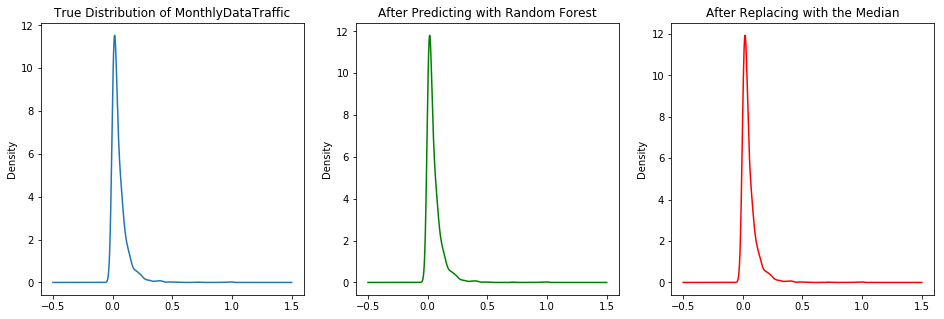

In [117]:
plot_comparison_numerical('MonthlyDataTraffic')

In [118]:
df['MonthlyDataTraffic'] = fill_nan(rfr_, columns, label)

#### DevicePrice

In [119]:
label = ['DevicePrice']

Random Forest Regressor:

In [120]:
rfr_, data, tscore, vscore = rfr(columns, label, n_iter = 100)

final tscore=0.882816 vscore=0.420948


MLPRegressor:

In [121]:
lr, data, tscore, vscore = regression(columns, label)  

final tscore=0.211499 vscore=0.143785


We get a quite acceptable $R^2$ score using Random Forest, thus, also on the basis of  what we would get if we replaced the missing data with the median, we proceed by using prediction.

In [122]:
median_nan = df['DevicePrice'].fillna((df['DevicePrice'].median()), inplace=False)

In [123]:
rf_nan =  fill_nan(rfr_, columns, label)

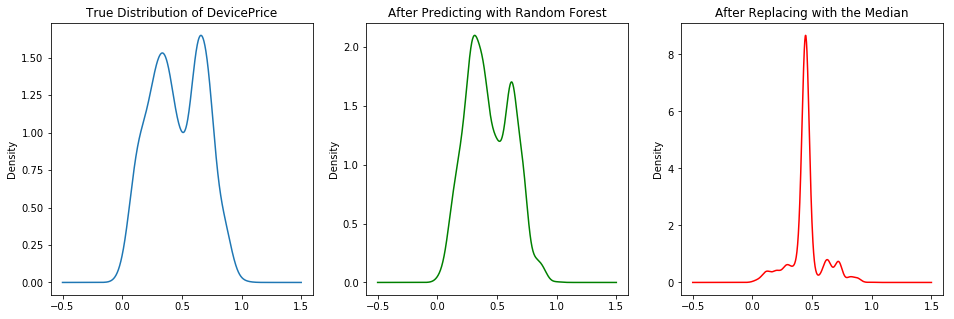

In [124]:
plot_comparison_numerical('DevicePrice')

In [125]:
df['DevicePrice'] = fill_nan(rfr_, columns, label)

#### MonthlySmsTrafficCount

In this case there is only one missing data. Hence we replace it with the median.

In [126]:
label = ['MonthlySmsTrafficCount']

In [127]:
df['MonthlySmsTrafficCount'].count()

1999

In [128]:
df['MonthlySmsTrafficCount'] = df['MonthlySmsTrafficCount'].fillna((df['MonthlySmsTrafficCount'].median()), inplace=False)

#### Popolazione

In [129]:
label = ['Popolazione']

Random Forest Regressor

In [130]:
rfr_, data, tscore, vscore = rfr(columns, label, n_iter = 100)

final tscore=0.801344 vscore=-0.0275982


In [131]:
lm, data, tscore, vscore = regression(columns, label)

final tscore=0.0125288 vscore=-0.03149


The results obtained with the predictions are very unsatisfactory.   
Let's see if we obtain something better by using the median.

In [132]:
median_nan = df['Popolazione'].fillna((df['Popolazione'].median()), inplace=False)

In [133]:
rf_nan =  fill_nan(rfr_, columns, label)

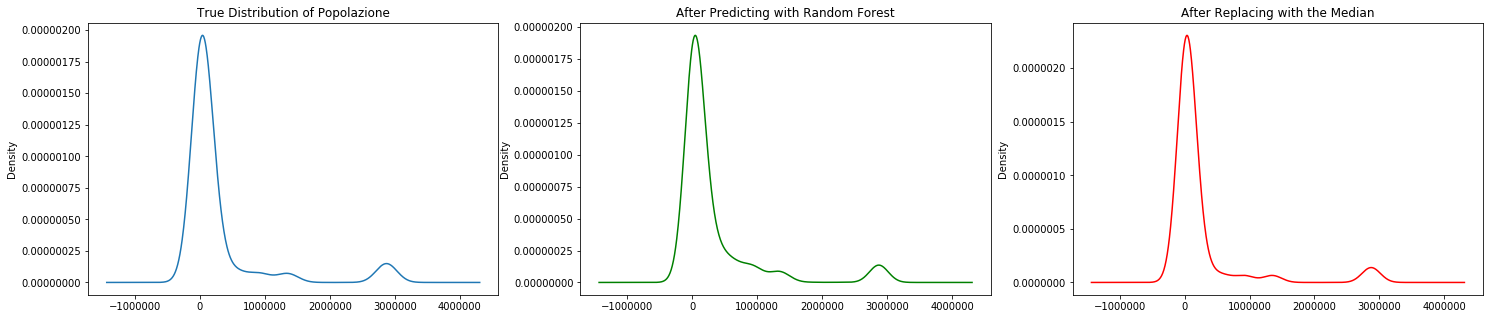

In [134]:
plot_comparison_numerical('Popolazione', figsize = (25, 5))

As we can see from the plots, replacing the missing values with the median seems to be a slight better choice.

In [135]:
df['Popolazione'] = df['Popolazione'].fillna((df['Popolazione'].median()), inplace=False)

---

We now transform CustomerAge into a numerical variable

In [136]:
d_age = {'(10, 20]':0.15, '(20, 30]':0.25, '(30, 40]':0.35, '(40, 50]':0.45, '(50, 60]':0.55, '(60, 70]':0.65,
           '(70, 80]':0.75, '(80, 90]':0.85}

df['CustomerAge'] = df['CustomerAge'].map(lambda z: d_age[z], na_action='ignore')

We Create a new dataframe with  one hot encoding applied to the categorical variable

In [137]:
df_ohe = pd.get_dummies(df, columns = ['DeviceOperatingSystem', 'GeoArea', 'GradoUrbanizzazione'], dummy_na = False)

---

Now that we have finally completed the missing data, we can pass to the main point of the challenge: clustering.

# Clustering

![](https://m.popkey.co/c5fee4/RZ1ZL.gif)

In [138]:
from sklearn.decomposition import PCA

Since we have the labels, in order to estimate the goodness of our cluster, we define the following function, purity, which is an external criteria of clustering quality.  
To compute it, each cluster is assigned to the label which is most frequent in the cluster, and then the accuracy of this assignment is measured by counting the number of correctly assigned objects and dividing by the total number of data points in the dataset.  
$${purity}(W, \mathbb{C}) = \frac{1}{N}\sum_k \max_j\vert w_k\cap c_j\vert$$
where $N$ stands for the total number of data points in the dataset (2000 in our case); $W$ is the set of clusters; $\mathbb{C}$ is the set of labels; $k$ is the number of clusters; $j$ is the number of labels.

In [139]:
def purity(df, labels, verbose = False):
    cluster_map = pd.DataFrame()
    cluster_map['ID'] = df.index.values
    cluster_map['Cluster'] = labels
    cluster_map = cluster_map.join(df['Product'])
    
    x = 0
    
    for i in np.unique(labels):
        c = cluster_map[cluster_map['Cluster'] == i]['Product'].value_counts() 
        x += max(c)
        
        if verbose:
            print('cluster:', i)
            print(c)
    
    return x / df.shape[0]

In [140]:
data_columns = ['CustomerAge', 'DataAllowance', 'DataArpu',
               'DeviceFlag4G', 'DeviceFlagSmartphone', 'MonthlyDataTraffic',
               'MonthlyVoiceTrafficCount', 'CustomerGender', 'CustomerImmigrant',
               'DevicePrice', 'MonthlySmsTrafficCount', 'DeviceOperatingSystem',
               'File-Transfer', 'Games', 'Instant-Messaging-Applications', 'Mail',
               'Music-Streaming', 'Network-Operation', 'P2P-Applications', 'Security',
               'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
               'Web-Applications', 'Popolazione', 'GradoUrbanizzazione','GeoArea']

numerical_columns = ['CustomerAge', 'DataAllowance', 'DataArpu',
                   'MonthlyDataTraffic', 'MonthlyVoiceTrafficCount',
                   'DevicePrice', 'MonthlySmsTrafficCount',
                   'File-Transfer', 'Games', 'Instant-Messaging-Applications', 'Mail',
                   'Music-Streaming', 'Network-Operation', 'P2P-Applications', 'Security',
                   'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
                   'Web-Applications']

Since our data is very heterogenous, applying traditional distances does not lead to satisfactory results.
Therefore, we define a new distance:

$$d(x,y) = \sqrt{\sum_{i} w_i^2 (x_i - y_i)^2}$$

In order to use this distance, we need to find the weights.

In order to find these weights, we apply Simulated Annealing to the K-Nearest-Neighbors algorithm, try to minimize the cost and then use the weights to transform our data.

In [141]:
X = df[numerical_columns]
labels = df['Product']

### K-nearest neighbors

In [142]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

Before applying Simulated Annealing we find the optimal parameters for K-Nearest-Neighbors.

In [143]:
def knn(X, labels, n_neighbors = 100, **knn_params): 
    scores = np.zeros(n_neighbors)
    
    for i in range(1, n_neighbors):
        neigh = KNeighborsClassifier(i, **knn_params)
        scores[i] = np.mean(cross_val_score(neigh, X, labels))
    
    plt.plot([i for i in range(1, n_neighbors)], scores[1:])
    print('n_neighbors:', np.argmax(scores)) 
    print('accuracy:', np.max(scores)) 

n_neighbors: 78
accuracy: 0.3724905657566966


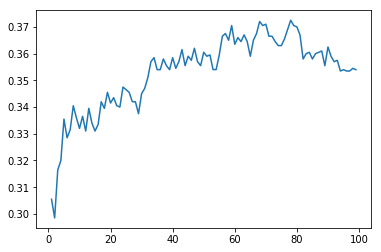

In [144]:
knn(X, labels)

Let's now apply Simulated Annealing but, as we can see, the improvement is not particularly relevant since we only gain a couple of percentage points.

In [145]:
import SimAnn
import Weights_Finder_knn

In [146]:
labels = df['Product']
X = X.as_matrix()

In [147]:
probl = Weights_Finder_knn.Weights_Finder(X, labels, n_neighbors = 78, step = 0.1)

probl, best = SimAnn.simann(probl, iters=5, seed=None,                       
                            beta0=25.0, beta1=175.0, beta_steps=5,
                            debug_delta_cost= True)

T= 0.04
  costs: current= 0.6315142089033823 best= 0.6310137038994796
  acceptance rate= 1.0
T= 0.016
  costs: current= 0.6335124612742029 best= 0.6310114527626556
  acceptance rate= 1.0
T= 0.01
  costs: current= 0.6345149742899026 best= 0.6310114527626556
  acceptance rate= 0.8
T= 0.007272727272727273
  costs: current= 0.6330104667624767 best= 0.6310114527626556
  acceptance rate= 1.0
T= 0.005714285714285714
  costs: current= 0.6300006900786246 best= 0.6300006900786246
  acceptance rate= 0.8
T= 0.0
  costs: current= 0.629500939953687 best= 0.629500939953687
  acceptance rate= 0.4


In [148]:
w = best.w

We start the unsupervised clustering with K-Means, being one of the most simple and popular algorithm in this field.

### K-Means

In [149]:
from sklearn.cluster import KMeans

In [150]:
from sklearn.metrics import silhouette_score

In [151]:
def k_means(X, n_components = 0, scale = False, verbose = False, df = df, **km_params): 
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
    dopca = n_components is None or n_components > 0
    
    if dopca:
            pca = PCA(n_components = n_components)
            X = pca.fit_transform(X)

    km = KMeans(**km_params)
    km.fit(X)
    score = purity(df, km.labels_, verbose)
    
    return km, score

We first try to find the right number of clusters.  
Using the silhouette metric, we notice that the quality of our clusters quickly decreases as we increase the number of clusters.

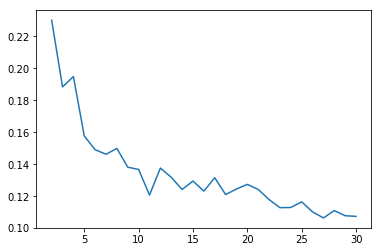

In [152]:
scores = []

for i in range(2, 31):
    
    km, puriry = k_means(X, n_clusters = i)
    scores.append(silhouette_score(X, km.labels_))
    
plt.plot(np.arange(2, 31), scores)

Looking at the graph we decide to use 6 as number of clusters.

__disclaimer__   
The functions check_distr(), prod_in_clust(), plot_hists() have been developed jointly with Group 8.

In [153]:
df['Numeric_Product'] = df['Product'].astype('category')

product_legend = [df['Numeric_Product'].cat.categories]

df['Numeric_Product'].cat.categories = np.arange(4)
df['Numeric_Product'] = df['Numeric_Product'].astype(np.int64)

In [154]:
product_distr = (df['Numeric_Product'].value_counts()[np.arange(4)] / 2000).as_matrix()
product_distr

array([0.225, 0.37 , 0.083, 0.322])

In [155]:
def cluster_distribution(km, df = df):
    products = df['Numeric_Product']
    labels = km.labels_
    
    clusters = np.unique(km.labels_)
    distr = np.zeros((km.n_clusters, 4))
    
    for cluster in clusters:
        mask = km.labels_ == cluster 
        distr[cluster] = products[mask].value_counts().sort_index().reindex([i for i in range(4)])
        
    distr = np.nan_to_num(distr)
    
    return distr / np.sum(distr, axis = 1).reshape(km.n_clusters, 1)

In [156]:
def cluster_composition(km, cluster, df = df):
    products = df['Numeric_Product']
    
    clusters = np.unique(km.labels_)
    
    distr = np.zeros((km.n_clusters, 4))
    
    mask = km.labels_ == cluster
    
    return products[mask]

In [157]:
def clusters_hist(km, df = df):
    k = km.n_clusters
    
    all_distr = cluster_distribution(km)
    
    fig = plt.figure(figsize = (15,10))
    
    for cluster in range(k):
        ax = fig.add_subplot(2, 3, cluster + 1)
        obs = cluster_composition(km, cluster, df)
        
        n = len(obs)
        
        tr_obs = n * product_distr
        
        decimal = tr_obs - tr_obs.astype(int)
        
        # we round up the element with the highest decimal part and round down the others
        
        up = decimal == decimal[np.argmax(decimal)]
        decimal[up] = np.ceil(decimal[up])
        decimal[~up] = np.floor(decimal[~up])
        
        tr_obs = (tr_obs.astype(int) + decimal).astype(int)
        tr_vals = np.hstack([np.ones(tr_obs[i], dtype = int)*i for i in range(4)])
        
        
        counts, bins, patches = plt.hist(obs, alpha = 0.5, stacked = True, bins = 4)
        ax.set_xticks(bins)
        ax.set_xticklabels(*list(product_legend))
        
        plt.hist(tr_vals, alpha = 0.5, bins = 4, color = 'r')       

In [158]:
km_, purity_ = k_means(X, n_clusters = 6)

By plotting the distribution of the products for each cluster against the original distribution of the clusters in the entire dataset, we notice that the distributions of the clusters closely resembles the distribution of the products in the dataset.  
This shows that the clustering fails to classify the users based on the products.  

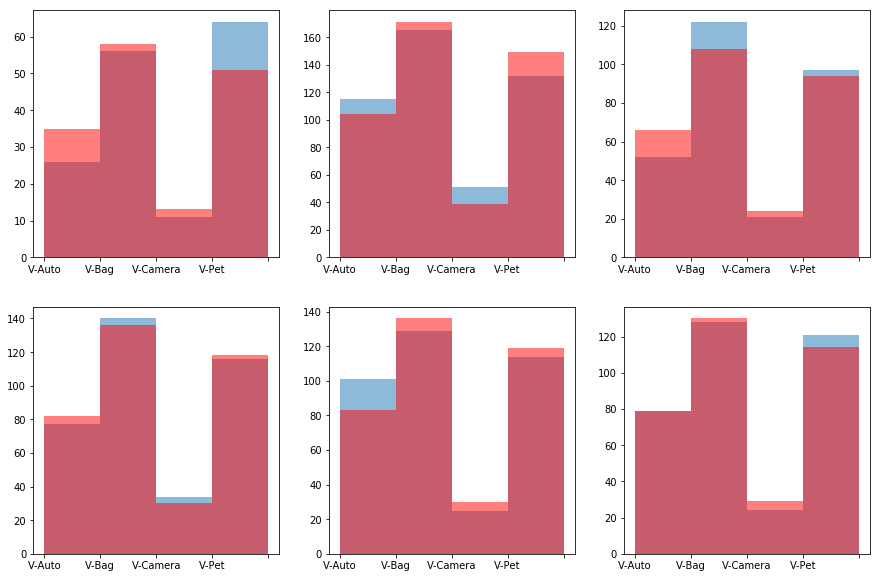

In [159]:
clusters_hist(km_)

If we try to find the number of clusters by looking at the purity score, we see that the score improves as we increase the clusters and obviously it reaches 1.0 when each data point has its own cluster.

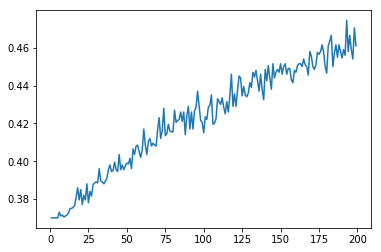

In [160]:
scores = []

for i in range(1, 100):
    
    km, purity_ = k_means(X, n_clusters = i)
    scores.append(purity_)
    
plt.plot(np.arange(1, 100), scores)

We now try to find a set of weights that improves our results through Simulated Annealing.
At the beginning we got very positive results applying Simulated Annealing on K-Means. However, trying to use the weights obtained outside of Simulated Annealing, no improvement was recorded. Looking for errors, we realized that it was due to a wrong delta cost.
This is due to the fact that k-means initializes the centroids at random every time you run it, thus making the delta cost wrong.
To overcome this issue we need to change the Simulated Annealing code: we do not update the cost through the delta_cost but we calculate the cost of the current instance every time.
After fixing the issue altough we do not get any a enhancement in the score.

In [161]:
import SimAnn_kmeans
import Weights_Finder_kmeans

In [162]:
probl = Weights_Finder_kmeans.Weights_Finder(X, df, n_clusters = 17, step = 0.1)

probl, best = SimAnn.simann(probl, iters=5, seed=None,                       
                            beta0=25.0, beta1=175.0, beta_steps=5,
                            debug_delta_cost= False)

T= 0.04
  costs: current= 0.6055 best= 0.6055
  acceptance rate= 0.8
T= 0.016
  costs: current= 0.6095000000000003 best= 0.5995
  acceptance rate= 1.0
T= 0.01
  costs: current= 0.6035000000000003 best= 0.5965000000000003
  acceptance rate= 0.8
T= 0.007272727272727273
  costs: current= 0.6025000000000003 best= 0.5965000000000003
  acceptance rate= 0.6
T= 0.005714285714285714
  costs: current= 0.6115000000000004 best= 0.5965000000000003
  acceptance rate= 0.6
T= 0.0
  costs: current= 0.6115000000000004 best= 0.5965000000000003
  acceptance rate= 0.2


In [163]:
w = best.w

We now turn to K-Prototype which should be more appropriate given our data, since it has the capability to handle both categorical and numerical variables.

### K-Prototypes

In [164]:
from kmodes.kprototypes import KPrototypes

In [165]:
X_kp = df[data_columns].as_matrix()

We define a function that returns the indices of the categorical data, which we will turn useful in the application of the K-prototypes algorithm.

In [166]:
def get_cat_indices(df):
    df_cat = df.select_dtypes(include=['object', 'int'])
    return [df.columns.get_loc(c) for c in df_cat.columns]

In [167]:
categorical_variables = get_cat_indices(df[data_columns])
categorical_variables

[3, 4, 7, 8, 11, 26, 27]

In [168]:
categorical_variables = [3, 4, 7, 8, 11, 26, 27]

In [169]:
kp = KPrototypes(n_clusters=4)

In [170]:
labels = kp.fit_predict(X_kp, categorical = categorical_variables)

As before, we obtain a score around 0.37. This is due to the fact that 0.37 is the percentage of V-Bag in the entire dataset, which is the same problem that had arised using K-Means.

In [171]:
purity(df, labels)

0.37

In [172]:
df['Product'].value_counts()

V-Bag       740
V-Pet       644
V-Auto      450
V-Camera    166
Name: Product, dtype: int64

In [173]:
740 / 2000

0.37

# The End